# Graph Utils

In [1]:
%run review/__common.py
%load_ext autoreload
%autoreload 2

[W1228 10:28:01.145052663 Utils.hpp:135] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function operator())


In [2]:
from modulus.utils.graphcast.icosahedral_mesh import (
    get_hierarchy_of_triangular_meshes_for_sphere,
    faces_to_edges,
    merge_meshes
)

from modulus.utils.graphcast.graph_utils import (
    create_graph,
    latlon2xyz,
    xyz2latlon,
    geospatial_rotation,
    azimuthal_angle,
    polar_angle
)

from torch import testing

## Mocking params for the Graph object instantiation

In [3]:
# re-create the lat_lon_grid var passed on to the constructor from the model
input_res: tuple = (721, 1440)
latitudes = torch.linspace(-90, 90, steps=input_res[0])
longitudes = torch.linspace(-180, 180, steps=input_res[1] + 1)[1:]
lat_lon_grid = torch.stack(torch.meshgrid(latitudes, longitudes, indexing="ij"), dim=-1)

# re-create the init arguments
mesh_level: int = 6
multimesh: bool = True
khop_neighbors: int = 0
dtype = torch.float

##### init body

# flatten lat/lon gird
lat_lon_grid_flat = lat_lon_grid.permute(2, 0, 1).view(2, -1).permute(1, 0)


# create the multi-mesh
_meshes = get_hierarchy_of_triangular_meshes_for_sphere(splits=mesh_level)
finest_mesh = _meshes[-1]  # get the last one in the list of meshes
finest_mesh_src, finest_mesh_dst = faces_to_edges(finest_mesh.faces)
finest_mesh_vertices = np.array(finest_mesh.vertices)
if multimesh:
    mesh = merge_meshes(_meshes)
    mesh_src, mesh_dst = faces_to_edges(mesh.faces)
    mesh_vertices = np.array(mesh.vertices)
else:
    pass
    # mesh = finest_mesh
    # self.mesh_src, self.mesh_dst = self.finest_mesh_src, self.finest_mesh_dst
    # self.mesh_vertices = self.finest_mesh_vertices
mesh_faces = mesh.faces

## Mocking params for the graph.create_mesh_graph() method call

In [4]:
verbose = True

mesh_graph = create_graph(
    mesh_src,
    mesh_dst,
    to_bidirected=True,
    add_self_loop=False,
    dtype=torch.int32,
)
mesh_pos = torch.tensor(
    mesh_vertices,
    dtype=torch.float32,
)
# mesh_graph = add_edge_features(mesh_graph, mesh_pos)
# ...

In [5]:
mesh_graph_original = create_graph(
    mesh_src,
    mesh_dst,
    to_bidirected=True,
    add_self_loop=False,
    dtype=torch.int32,
)

mesh_graph_simplified = create_graph(
    mesh_src,
    mesh_dst,
    to_bidirected=True,
    add_self_loop=False,
    dtype=torch.int32,
)

## add_edge_features(...)

```python
    """Adds edge features to the graph.

    Parameters
    ----------
    graph : DGLGraph
        The graph to add edge features to.
    pos : Tensor
        The node positions.
    normalize : bool, optional
        Whether to normalize the edge features, by default True

    Returns
    -------
    DGLGraph
        The graph with edge features.
    """
```

Getting original values:

In [6]:
from modulus.utils.graphcast.graph_utils import add_edge_features as add_edge_features_original

mesh_graph_original = add_edge_features_original(mesh_graph_original, mesh_pos)
mesh_graph_original.edata["x"]

tensor([[-5.2573e-01, -8.0902e-01, -2.6287e-01,  1.0000e+00],
        [-5.2573e-01,  8.0902e-01, -2.6287e-01,  1.0000e+00],
        [-5.2573e-01,  0.0000e+00,  8.5065e-01,  1.0000e+00],
        ...,
        [-2.0300e-04,  1.8121e-02,  7.5921e-03,  1.9649e-02],
        [-2.0334e-04, -1.8228e-02, -7.3653e-03,  1.9661e-02],
        [-2.0322e-04, -2.6239e-03, -1.9484e-02,  1.9661e-02]])

Reviewing what the function does internally.

In [7]:
# invoked as: mesh_graph = add_edge_features(mesh_graph, mesh_pos)
# defined as: def add_edge_features(graph: DGLGraph, pos: Tensor, normalize: bool = True) -> DGLGraph:

graph = mesh_graph
pos = mesh_pos
normalize = True

**Comment:** The vertices are returned (`pos`), and the edges information (source and destination vertex indices).

The body:

In [8]:
src_pos = dst_pos = pos
src, dst = graph.edges()

src_pos.shape, dst_pos.shape, src.shape, dst.shape

(torch.Size([40962, 3]),
 torch.Size([40962, 3]),
 torch.Size([327660]),
 torch.Size([327660]))

In [9]:
src_pos, dst_pos = src_pos[src.long()], dst_pos[dst.long()]
dst_latlon = xyz2latlon(dst_pos, unit="rad")
dst_lat, dst_lon = dst_latlon[:, 0], dst_latlon[:, 1]

**Comment:** The source and destination vertex indices are transformed to vertices themselves.

**Comment:** The vectors in 3D space are flattened on a lat/lon coordinate system. How is this projection looking?

To make sense of the upcoming visualisazion, add axises:

In [10]:
axises = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=torch.float32)

axises_latlon = xyz2latlon(axises, unit="rad")
axises_lat, axises_lon = axises_latlon[:, 0], axises_latlon[:, 1]

print(f"Axis x -> Lat: {axises_lat[0]:.2f}, Lon: {axises_lon[0]:.2f}")
print(f"Axis y -> Lat: {axises_lat[1]:.2f}, Lon: {axises_lon[1]:.2f}")
print(f"Axis z -> Lat: {axises_lat[2]:.2f}, Lon: {axises_lon[2]:.2f}")

Axis x -> Lat: 0.00, Lon: 0.00
Axis y -> Lat: 0.00, Lon: 1.57
Axis z -> Lat: 1.57, Lon: 0.00


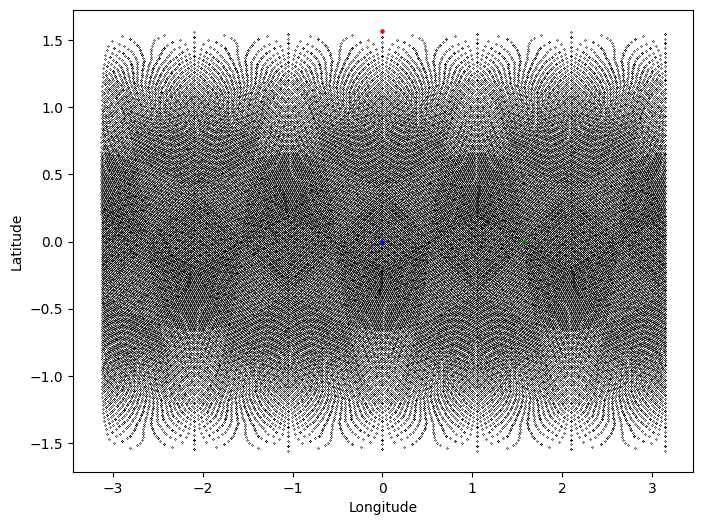

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(dst_lon, dst_lat, color='black', s=.01, label="2D Points")

plt.scatter(axises_lon[0], axises_lat[0], color='blue', s=5, label="x-axis")
plt.scatter(axises_lon[1], axises_lat[1], color='green', s=5, label="y-axis")
plt.scatter(axises_lon[2], axises_lat[2], color='red', s=5, label="z-axis")

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

**Comment:** Although the poles have a visibly lower density of points (as expected), artifacts can be seen in the center of the picture. Does this indicate a different density of points?

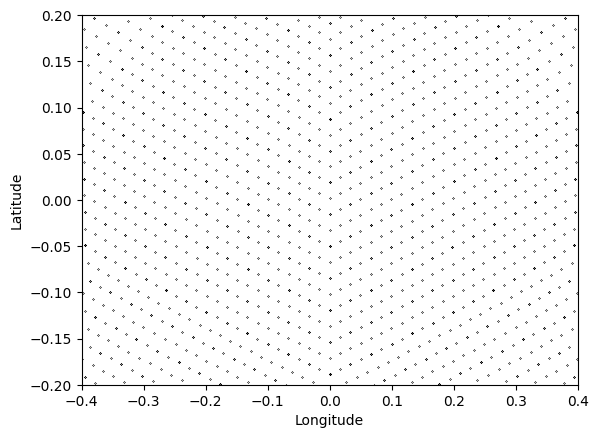

In [12]:
# Zoom in
plt.scatter(dst_lon, dst_lat, color='black', s=.01, label="2D Points")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-0.4, 0.4)
plt.ylim(-0.2, 0.2)
plt.show()

In [13]:
dst_latlon_unique = np.unique(dst_latlon, axis=0)
dst_lat_unique, dst_lon_unique = dst_latlon_unique[:, 0], dst_latlon_unique[:, 1]

dst_latlon.shape, dst_latlon_unique.shape

(torch.Size([327660, 2]), (40962, 2))

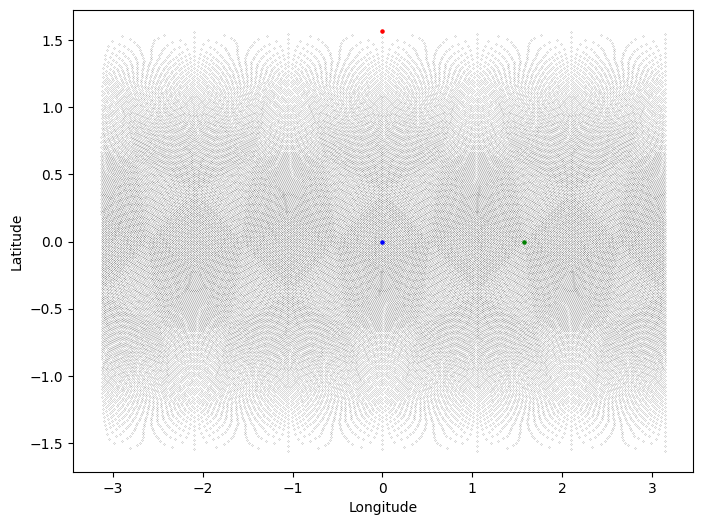

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(dst_lon_unique, dst_lat_unique, color='black', s=.01, label="2D Points")

plt.scatter(axises_lon[0], axises_lat[0], color='blue', s=5, label="x-axis")
plt.scatter(axises_lon[1], axises_lat[1], color='green', s=5, label="y-axis")
plt.scatter(axises_lon[2], axises_lat[2], color='red', s=5, label="z-axis")

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

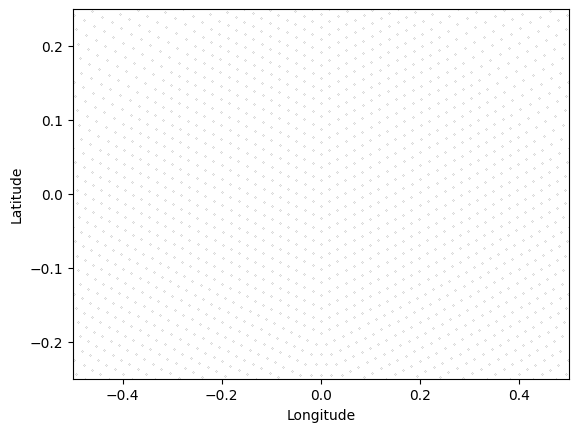

In [15]:
# Zoom in
plt.scatter(dst_lon_unique, dst_lat_unique, color='black', s=.01, label="2D Points")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-0.5, 0.5)
plt.ylim(-0.25, 0.25)
plt.show()

**Comment:** Even excluding duplicates, strange artifacts can be seen in the dense plot. In the zoomed one they seem evently distributed. Further check density through an histogram/heatmap.

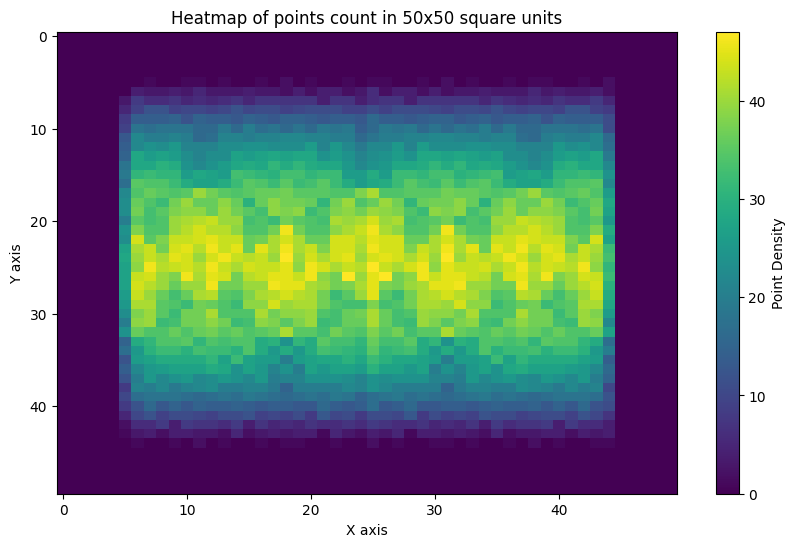

In [16]:
num_bins = 50
heatmap, xedges, yedges = np.histogram2d(dst_lon_unique, dst_lat_unique, bins=num_bins, range=[[-4, 4], [-2, 2]])

# Plotting the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(heatmap.T, cmap='viridis', aspect='auto')
plt.colorbar(label='Point Density')

# Add labels, ranges and title
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title(f"Heatmap of points count in {num_bins}x{num_bins} square units")

# Show the plot
plt.show()

In [17]:
# Selecting data from the equator
equator_data = heatmap[(num_bins // 2 - 15):(num_bins // 2 + 15), num_bins // 2]
equator_data, min(equator_data), max(equator_data)

(array([44., 42., 46., 43., 41., 44., 43., 43., 45., 39., 46., 44., 41.,
        43., 42., 47., 43., 41., 44., 46., 39., 45., 43., 43., 44., 41.,
        43., 46., 42., 44.]),
 39.0,
 47.0)

**Comment:** The heatmap confirms that there are areas less populated (-17% compared to the max value), and areas more populated. 

TODO: Understand if this is problematic for the model abilities.

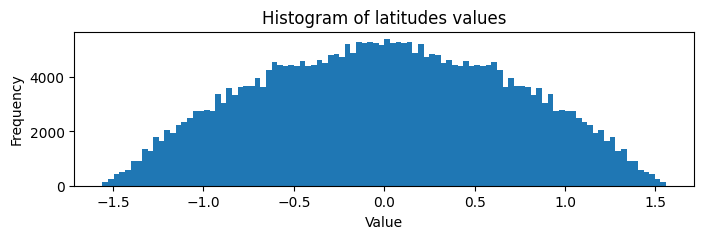

In [18]:
plt.figure(figsize=(8, 2))
plt.hist(dst_lat, bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of latitudes values')
plt.show()

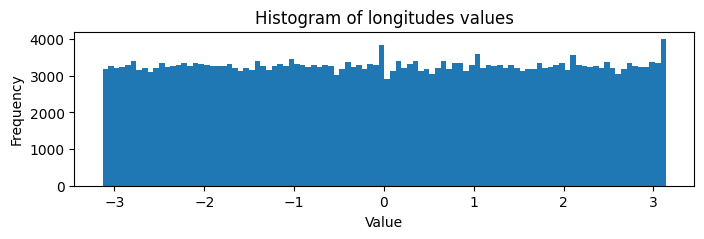

In [19]:
plt.figure(figsize=(8, 2))
plt.hist(dst_lon, bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of longitudes values')
plt.show()

**Comment:** The latitudes are as expected. Strangely, there are peaks near the pi multiples, where the distribution is supposed to be uniform.

TODO: Find out why and if this is problematic for the model.

### Making sense of the azimuthal and polar geospatial rotations

In [20]:
# azimuthal & polar rotation
theta_azimuthal = azimuthal_angle(dst_lon)
theta_polar = polar_angle(dst_lat)

edited_src_pos = geospatial_rotation(src_pos, theta=theta_azimuthal, axis="z", unit="rad")
edited_dst_pos = geospatial_rotation(dst_pos, theta=theta_azimuthal, axis="z", unit="rad")

# y values should be zero
try:
    testing.assert_close(edited_dst_pos[:, 1], torch.zeros_like(edited_dst_pos[:, 1]))
except ValueError:
    raise ValueError("Invalid projection of edge nodes to local ccordinate system")
edited_src_pos = geospatial_rotation(edited_src_pos, theta=theta_polar, axis="y", unit="rad")
edited_dst_pos = geospatial_rotation(edited_dst_pos, theta=theta_polar, axis="y", unit="rad")
# x values should be one, y & z values should be zero
try:
    testing.assert_close(edited_dst_pos[:, 0], torch.ones_like(edited_dst_pos[:, 0]))
    testing.assert_close(edited_dst_pos[:, 1], torch.zeros_like(edited_dst_pos[:, 1]))
    testing.assert_close(edited_dst_pos[:, 2], torch.zeros_like(edited_dst_pos[:, 2]))
except ValueError:
    raise ValueError("Invalid projection of edge nodes to local ccordinate system")

In [21]:
axises = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=torch.float32)
axises_latlon = xyz2latlon(axises, unit="rad")
axises_lat, axises_lon = axises_latlon[:, 0], axises_latlon[:, 1]

theta_azimuthal = azimuthal_angle(axises_lon)
theta_polar = polar_angle(axises_lat)

edited_axises = geospatial_rotation(axises, theta=theta_azimuthal, axis="z", unit="rad")
edited_axises = geospatial_rotation(edited_axises, theta=theta_polar, axis="y", unit="rad")

In [22]:
edited_src_latlon = xyz2latlon(edited_src_pos, unit="rad")
edited_src_lat, edited_src_lon = edited_src_latlon[:, 0], edited_src_latlon[:, 1]

edited_dst_latlon = xyz2latlon(edited_dst_pos, unit="rad")
edited_dst_lat, edited_dst_lon = edited_dst_latlon[:, 0], edited_dst_latlon[:, 1]

edited_axises_latlon = xyz2latlon(edited_axises, unit="rad")
edited_axises_lat, edited_axises_lon = edited_axises_latlon[:, 0], edited_axises_latlon[:, 1]

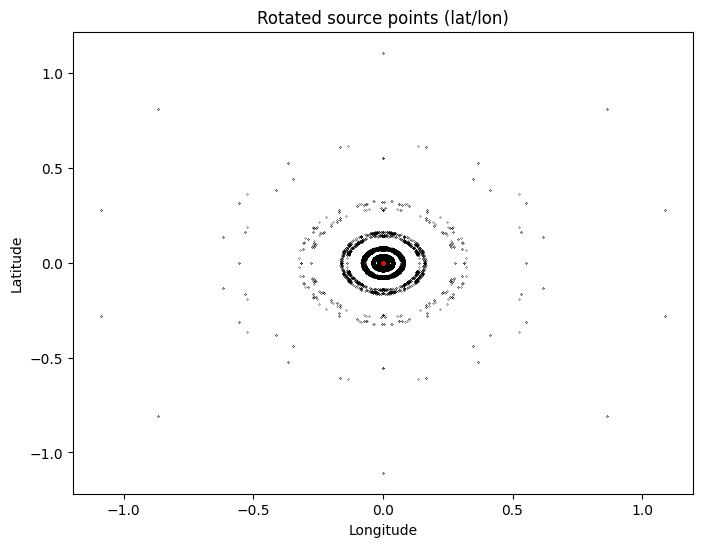

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(edited_src_lon, edited_src_lat, color='black', s=.01, label="2D Points")

plt.scatter(edited_axises_lon[0], edited_axises_lat[0], color='blue', s=5, label="x-axis")
plt.scatter(edited_axises_lon[1], edited_axises_lat[1], color='green', s=5, label="y-axis")
plt.scatter(edited_axises_lon[2], edited_axises_lat[2], color='red', s=5, label="z-axis")

plt.title("Rotated source points (lat/lon)")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

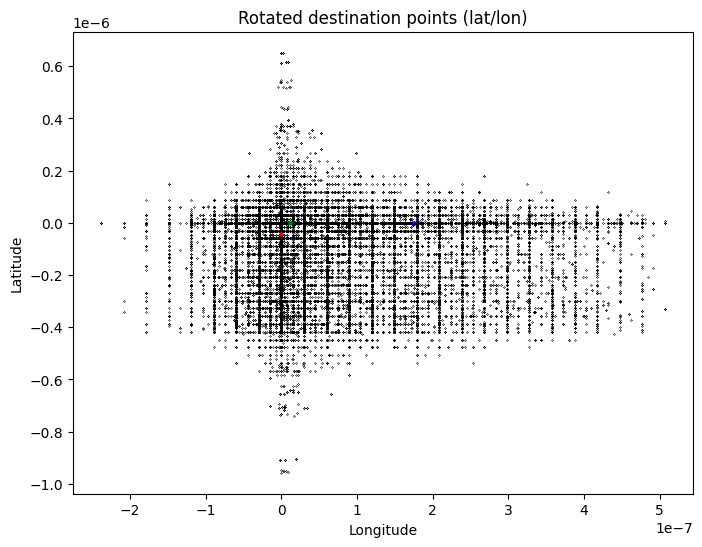

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(edited_dst_lon, edited_dst_lat, color='black', s=.01, label="2D Points")

plt.scatter(edited_axises_lon[0], edited_axises_lat[0], color='blue', s=5, label="x-axis")
plt.scatter(edited_axises_lon[1], edited_axises_lat[1], color='green', s=5, label="y-axis")
plt.scatter(edited_axises_lon[2], edited_axises_lat[2], color='red', s=5, label="z-axis")

plt.title("Rotated destination points (lat/lon)")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

**Comment:** The source points are rotated around the destination points. Thus, the plot for the source points is clearer, as there are 6 mesh refinements contained in the graph. 

In [25]:
# prepare edge features
edited_disp = edited_src_pos - edited_dst_pos
edited_disp_norm = torch.linalg.norm(edited_disp, dim=-1, keepdim=True)

# normalize using the longest edge
if normalize:
    max_disp_norm = torch.max(edited_disp_norm)
    graph.edata["x"] = torch.cat((edited_disp / max_disp_norm, edited_disp_norm / max_disp_norm), dim=-1)
else:
    pass
    #graph.edata["x"] = torch.cat((disp, disp_norm), dim=-1)

In [26]:
graph.edata["x"]

tensor([[-5.2573e-01, -8.0902e-01, -2.6287e-01,  1.0000e+00],
        [-5.2573e-01,  8.0902e-01, -2.6287e-01,  1.0000e+00],
        [-5.2573e-01,  0.0000e+00,  8.5065e-01,  1.0000e+00],
        ...,
        [-2.0300e-04,  1.8121e-02,  7.5921e-03,  1.9649e-02],
        [-2.0334e-04, -1.8228e-02, -7.3653e-03,  1.9661e-02],
        [-2.0322e-04, -2.6239e-03, -1.9484e-02,  1.9661e-02]])

In [27]:
# Recall from above
mesh_graph_original.edata["x"]

tensor([[-5.2573e-01, -8.0902e-01, -2.6287e-01,  1.0000e+00],
        [-5.2573e-01,  8.0902e-01, -2.6287e-01,  1.0000e+00],
        [-5.2573e-01,  0.0000e+00,  8.5065e-01,  1.0000e+00],
        ...,
        [-2.0300e-04,  1.8121e-02,  7.5921e-03,  1.9649e-02],
        [-2.0334e-04, -1.8228e-02, -7.3653e-03,  1.9661e-02],
        [-2.0322e-04, -2.6239e-03, -1.9484e-02,  1.9661e-02]])

In [28]:
np.allclose(graph.edata["x"].numpy(), mesh_graph_original.edata["x"].numpy())

True

**Comment:** It is not clear what the rotations are supposed to do. What if they are not applied?

In [29]:
from dgl import DGLGraph
from torch import Tensor

def add_edge_features_simplified(graph: DGLGraph, pos: Tensor, normalize: bool = True) -> DGLGraph:
    if isinstance(pos, tuple):
        src_pos, dst_pos = pos
    else:
        src_pos = dst_pos = pos
    src, dst = graph.edges()

    src_pos, dst_pos = src_pos[src.long()], dst_pos[dst.long()]
    # dst_latlon = xyz2latlon(dst_pos, unit="rad")
    # dst_lat, dst_lon = dst_latlon[:, 0], dst_latlon[:, 1]

    # # azimuthal & polar rotation
    # theta_azimuthal = azimuthal_angle(dst_lon)
    # theta_polar = polar_angle(dst_lat)

    # src_pos = geospatial_rotation(src_pos, theta=theta_azimuthal, axis="z", unit="rad")
    # dst_pos = geospatial_rotation(dst_pos, theta=theta_azimuthal, axis="z", unit="rad")
    # # y values should be zero
    # try:
    #     testing.assert_close(dst_pos[:, 1], torch.zeros_like(dst_pos[:, 1]))
    # except ValueError:
    #     raise ValueError("Invalid projection of edge nodes to local ccordinate system")
    # src_pos = geospatial_rotation(src_pos, theta=theta_polar, axis="y", unit="rad")
    # dst_pos = geospatial_rotation(dst_pos, theta=theta_polar, axis="y", unit="rad")
    # # x values should be one, y & z values should be zero
    # try:
    #     testing.assert_close(dst_pos[:, 0], torch.ones_like(dst_pos[:, 0]))
    #     testing.assert_close(dst_pos[:, 1], torch.zeros_like(dst_pos[:, 1]))
    #     testing.assert_close(dst_pos[:, 2], torch.zeros_like(dst_pos[:, 2]))
    # except ValueError:
    #     raise ValueError("Invalid projection of edge nodes to local ccordinate system")

    # prepare edge features
    disp = src_pos - dst_pos
    disp_norm = torch.linalg.norm(disp, dim=-1, keepdim=True)

    # normalize using the longest edge
    if normalize:
        max_disp_norm = torch.max(disp_norm)
        graph.edata["x"] = torch.cat(
            (disp / max_disp_norm, disp_norm / max_disp_norm), dim=-1
        )
    else:
        graph.edata["x"] = torch.cat((disp, disp_norm), dim=-1)
    return graph

mesh_graph_simplified = add_edge_features_simplified(mesh_graph_simplified, mesh_pos)
mesh_graph_simplified.edata["x"]

tensor([[ 0.7558,  0.3090, -0.5774,  1.0000],
        [-0.1103,  0.8090, -0.5774,  1.0000],
        [ 0.1784,  0.3090,  0.9342,  1.0000],
        ...,
        [-0.0095, -0.0157,  0.0071,  0.0196],
        [ 0.0092,  0.0159, -0.0070,  0.0197],
        [-0.0035,  0.0061, -0.0184,  0.0197]])

Comparin the displacement values:

In [30]:
mesh_graph_original.edata["x"]

tensor([[-5.2573e-01, -8.0902e-01, -2.6287e-01,  1.0000e+00],
        [-5.2573e-01,  8.0902e-01, -2.6287e-01,  1.0000e+00],
        [-5.2573e-01,  0.0000e+00,  8.5065e-01,  1.0000e+00],
        ...,
        [-2.0300e-04,  1.8121e-02,  7.5921e-03,  1.9649e-02],
        [-2.0334e-04, -1.8228e-02, -7.3653e-03,  1.9661e-02],
        [-2.0322e-04, -2.6239e-03, -1.9484e-02,  1.9661e-02]])

In [31]:
mesh_graph.edata["x"]

tensor([[-5.2573e-01, -8.0902e-01, -2.6287e-01,  1.0000e+00],
        [-5.2573e-01,  8.0902e-01, -2.6287e-01,  1.0000e+00],
        [-5.2573e-01,  0.0000e+00,  8.5065e-01,  1.0000e+00],
        ...,
        [-2.0300e-04,  1.8121e-02,  7.5921e-03,  1.9649e-02],
        [-2.0334e-04, -1.8228e-02, -7.3653e-03,  1.9661e-02],
        [-2.0322e-04, -2.6239e-03, -1.9484e-02,  1.9661e-02]])

Comparing norms distribution:

In [32]:
mesh_graph.edata["x"][:, 3]

tensor([1.0000, 1.0000, 1.0000,  ..., 0.0196, 0.0197, 0.0197])

In [33]:
mesh_graph_original.edata["x"][:, 3]

tensor([1.0000, 1.0000, 1.0000,  ..., 0.0196, 0.0197, 0.0197])

In [34]:
mesh_graph_simplified.edata["x"][:, 3]

tensor([1.0000, 1.0000, 1.0000,  ..., 0.0196, 0.0197, 0.0197])

In [35]:
np.allclose(mesh_graph_simplified.edata["x"][:, 3].numpy(), mesh_graph_original.edata["x"][:, 3].numpy())

True

In [36]:
np.allclose(mesh_graph_simplified.edata["x"][:, 3].numpy(), mesh_graph.edata["x"][:, 3].numpy())

True

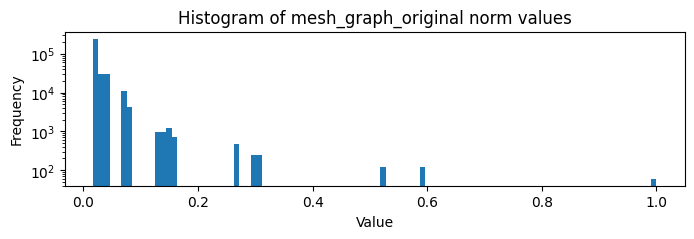

In [37]:
plt.figure(figsize=(8, 2))
plt.hist(mesh_graph_original.edata["x"][:, 3], bins=100)
plt.yscale('log')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of mesh_graph_original norm values')
plt.show()

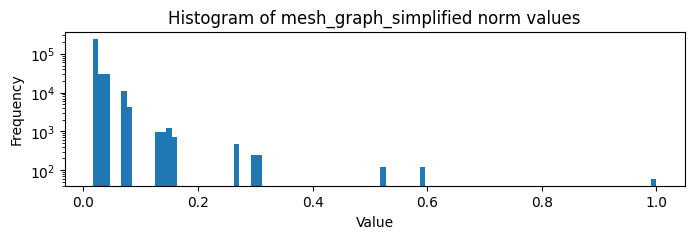

In [38]:
plt.figure(figsize=(8, 2))
plt.hist(mesh_graph_simplified.edata["x"][:, 3], bins=100)
plt.yscale('log')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of mesh_graph_simplified norm values')
plt.show()

In [39]:
mesh_graph_simplified.edata["x"][:, 0:3].shape

torch.Size([327660, 3])

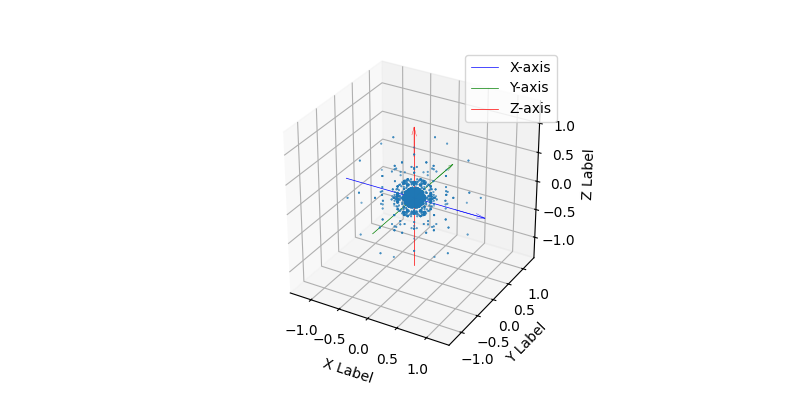

In [40]:
%matplotlib widget

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, projection='3d')

# Add thin X, Y, Z axis lines
v_range = [-1.2, 1.2]
ax.plot(v_range, [0, 0], [0, 0], color='blue', linewidth=.5, label='X-axis')
ax.plot([0, 0], v_range, [0, 0], color='green', linewidth=.5, label='Y-axis')
ax.plot([0, 0], [0, 0], v_range, color='red', linewidth=.5, label='Z-axis')

# Add small arrows at the end of each axis
arrow_length = 0.5
arrow_starts = v_range[-1] - arrow_length
ax.quiver(arrow_starts, 0, 0, arrow_length, 0, 0, color='blue', linewidth=.25)
ax.quiver(0, arrow_starts, 0, 0, arrow_length, 0, color='green', linewidth=.25)
ax.quiver(0, 0, arrow_starts, 0, 0, arrow_length, color='red', linewidth=.25)

# Plot data
ax.scatter3D(mesh_graph_simplified.edata["x"][:, 0], mesh_graph_simplified.edata["x"][:, 1], mesh_graph_simplified.edata["x"][:, 2], s=.2)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_aspect('equal')
ax.legend()
plt.show()

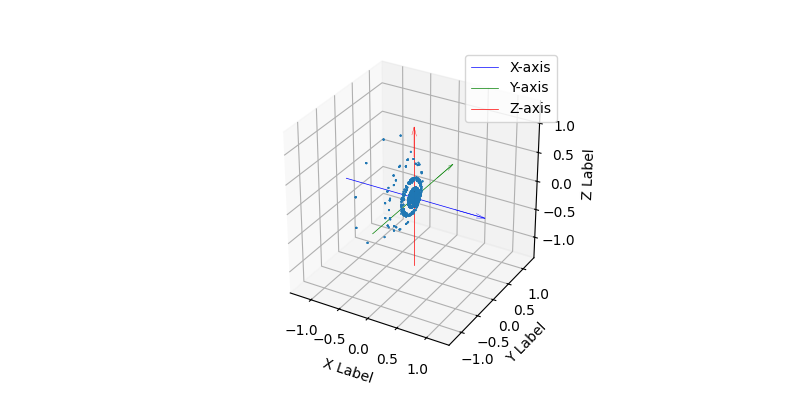

In [41]:
%matplotlib widget

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, projection='3d')

# Add thin X, Y, Z axis lines
v_range = [-1.2, 1.2]
ax.plot(v_range, [0, 0], [0, 0], color='blue', linewidth=.5, label='X-axis')
ax.plot([0, 0], v_range, [0, 0], color='green', linewidth=.5, label='Y-axis')
ax.plot([0, 0], [0, 0], v_range, color='red', linewidth=.5, label='Z-axis')

# Add small arrows at the end of each axis
arrow_length = 0.5
arrow_starts = v_range[-1] - arrow_length
ax.quiver(arrow_starts, 0, 0, arrow_length, 0, 0, color='blue', linewidth=.25)
ax.quiver(0, arrow_starts, 0, 0, arrow_length, 0, color='green', linewidth=.25)
ax.quiver(0, 0, arrow_starts, 0, 0, arrow_length, color='red', linewidth=.25)

# Plot data
ax.scatter3D(mesh_graph_original.edata["x"][:, 0], mesh_graph_original.edata["x"][:, 1], mesh_graph_original.edata["x"][:, 2], s=.2)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_aspect('equal')
ax.legend()
plt.show()

In [42]:
o = mesh_graph_original.edata["x"][:, 0:3].numpy()
s = mesh_graph_simplified.edata["x"][:, 0:3].numpy()

o.shape, s.shape

((327660, 3), (327660, 3))

In [43]:
np.unique(o, axis=0).shape, np.unique(s, axis=0).shape

((317566, 3), (163456, 3))

## add_node_features(...)

```python
    """Adds cosine of latitude, sine and cosine of longitude as the node features
    to the graph.
    """
```

In [44]:
# invoked as: mesh_graph = add_node_features(mesh_graph, mesh_pos)
# defined as: def add_node_features(graph: DGLGraph, pos: Tensor) -> DGLGraph:

graph = mesh_graph
pos = mesh_pos
normalize = True

Body:

In [45]:
latlon = xyz2latlon(pos)
lat, lon = latlon[:, 0], latlon[:, 1]
graph.ndata["x"] = torch.stack(
    (torch.cos(lat), torch.sin(lon), torch.cos(lon)), dim=-1
)

In [46]:
graph.ndata["x"]

tensor([[-0.1822, -0.3048, -0.9524],
        [-0.7078,  0.5806,  0.8142],
        [-0.7078,  0.0000,  1.0000],
        ...,
        [ 0.8639, -0.9999,  0.0146],
        [ 0.3111, -0.5576, -0.8301],
        [ 0.9968, -0.4117, -0.9113]])

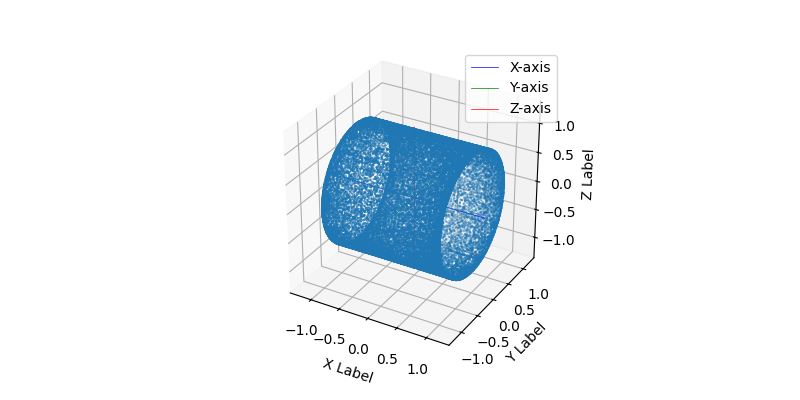

In [47]:
%matplotlib widget

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, projection='3d')

# Add thin X, Y, Z axis lines
v_range = [-1.2, 1.2]
ax.plot(v_range, [0, 0], [0, 0], color='blue', linewidth=.5, label='X-axis')
ax.plot([0, 0], v_range, [0, 0], color='green', linewidth=.5, label='Y-axis')
ax.plot([0, 0], [0, 0], v_range, color='red', linewidth=.5, label='Z-axis')

# Add small arrows at the end of each axis
arrow_length = 0.5
arrow_starts = v_range[-1] - arrow_length
ax.quiver(arrow_starts, 0, 0, arrow_length, 0, 0, color='blue', linewidth=.25)
ax.quiver(0, arrow_starts, 0, 0, arrow_length, 0, color='green', linewidth=.25)
ax.quiver(0, 0, arrow_starts, 0, 0, arrow_length, color='red', linewidth=.25)

# Plot data
ax.scatter3D(graph.ndata["x"][:, 0], graph.ndata["x"][:, 1], graph.ndata["x"][:, 2], s=.2)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_aspect('equal')
ax.legend()
plt.show()

## max_edge_length()

In [49]:
# invoked as: max_edge_len = max_edge_length(self.finest_mesh_vertices, self.finest_mesh_src, self.finest_mesh_dst)
# defined as: def max_edge_length(vertices: List[List[float]], source_nodes: List[int], destination_nodes: List[int]) -> float:
vertices = finest_mesh_vertices
finest_mesh_src, finest_mesh_dst = faces_to_edges(finest_mesh.faces)
source_nodes = finest_mesh_src
destination_nodes = finest_mesh_dst

In [54]:
vertices, vertices.shape

(array([[ 0.49112344,  0.8506508 ,  0.18759246],
        [-0.303531  ,  0.5257311 ,  0.7946544 ],
        [ 0.607062  ,  0.        ,  0.7946544 ],
        ...,
        [-0.75296974,  0.56828874,  0.3317899 ],
        [-0.73962533,  0.57862514,  0.3437255 ],
        [-0.7433136 ,  0.5850135 ,  0.32441333]], dtype=float32),
 (40962, 3))

In [53]:
source_coords = vertices_np[source_nodes]
dest_coords = vertices_np[destination_nodes]

source_coords, source_coords.shape

(array([[ 0.49112344,  0.8506508 ,  0.18759246],
        [ 0.48093182,  0.85333383,  0.20131059],
        [ 0.49854282,  0.8431661 ,  0.20131059],
        ...,
        [-0.7433136 ,  0.5850135 ,  0.32441333],
        [-0.75649637,  0.57455426,  0.31241098],
        [-0.75296974,  0.56828874,  0.3317899 ]], dtype=float32),
 (245760, 3))

In [56]:
# Compute the squared distances for all edges
squared_differences = np.sum((source_coords - dest_coords) ** 2, axis=1)
squared_differences, squared_differences.shape

(array([0.00029925, 0.00029925, 0.00029934, ..., 0.00042737, 0.00042724,
        0.00042737], dtype=float32),
 (245760,))

In [57]:
# Compute the maximum edge length
max_length = np.sqrt(np.max(squared_differences))
max_length, max_length.shape

(0.02067309, ())

## create_heterograph()

```python
"""Creates a heterogeneous DGL graph from an adj matrix in COO format."""
```

From https://docs.dgl.ai/en/0.8.x/guide/graph-heterogeneous.html: "A heterogeneous graph can have nodes and edges of different types." -> Needed to distinguish between mash and grid nodes?

In [ ]:
# invoked as: g2m_graph = create_heterograph(src, dst, ("grid", "g2m", "mesh"), dtype=torch.int32)
# defined as: def create_heterograph(
#     src: List,
#     dst: List,
#     labels: str,
#     dtype: torch.dtype = torch.int32,
#     num_nodes_dict: dict = None,
# ) -> DGLGraph:



## get_face_centroids()

In [66]:
vertices = mesh.vertices
faces = mesh.faces

centroids = []

for face in faces[:1]:
    # Extract the coordinates of the vertices for the current face
    v0 = vertices[face[0]]
    v1 = vertices[face[1]]
    v2 = vertices[face[2]]

    print(v0, v1, v2)
    print(torch.linalg.norm(torch.tensor(v0)), torch.linalg.norm(torch.tensor(v1)), torch.linalg.norm(torch.tensor(v2)))

    # Compute the centroid of the triangle
    centroid = (
        (v0[0] + v1[0] + v2[0]) / 3,
        (v0[1] + v1[1] + v2[1]) / 3,
        (v0[2] + v1[2] + v2[2]) / 3,
    )

    print(centroid)
    print(torch.linalg.norm(torch.tensor(centroid)))

[0.49112344 0.8506508  0.18759246] [-0.303531   0.5257311  0.7946544] [0.607062  0.        0.7946544]
tensor(1.0000) tensor(1.0000) tensor(1.0000)
(0.2648848096529643, 0.45879395802815753, 0.5923004150390625)
tensor(0.7947, dtype=torch.float64)


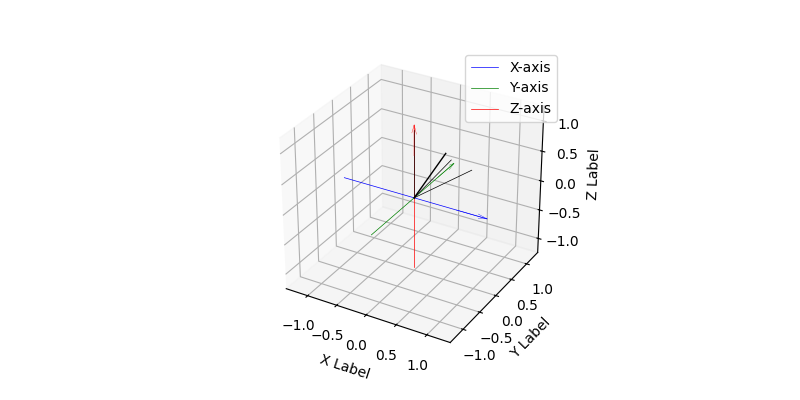

In [60]:
%matplotlib widget

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, projection='3d')

# Add thin X, Y, Z axis lines
v_range = [-1.2, 1.2]
ax.plot(v_range, [0, 0], [0, 0], color='blue', linewidth=.5, label='X-axis')
ax.plot([0, 0], v_range, [0, 0], color='green', linewidth=.5, label='Y-axis')
ax.plot([0, 0], [0, 0], v_range, color='red', linewidth=.5, label='Z-axis')

# Add small arrows at the end of each axis
arrow_length = 0.5
arrow_starts = v_range[-1] - arrow_length
ax.quiver(arrow_starts, 0, 0, arrow_length, 0, 0, color='blue', linewidth=.25)
ax.quiver(0, arrow_starts, 0, 0, arrow_length, 0, color='green', linewidth=.25)
ax.quiver(0, 0, arrow_starts, 0, 0, arrow_length, color='red', linewidth=.25)

# Plot data
ax.plot([0, v0[0]], [0, v0[1]], [0, v0[2]], color='black', linewidth=.5)
ax.plot([0, v1[0]], [0, v1[1]], [0, v1[2]], color='black', linewidth=.5)
ax.plot([0, v2[0]], [0, v2[1]], [0, v2[2]], color='black', linewidth=.5)
ax.plot([0, centroid[0]], [0, centroid[1]], [0, centroid[2]], color='black', linewidth=1)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_aspect('equal')
ax.legend()
plt.show()

**Comment:** The centroid is indeed in the middle of the surface, but it is not normalised back.